# Multimodal Masked Autoencoder test

Motivated by [NASA and IBM's Prithvi](https://arxiv.org/abs/2412.02732) and [EPFL's MultiMAE](https://arxiv.org/abs/2204.01678), we seek to construct a [Vision Transformer](https://arxiv.org/abs/2010.11929)-based Multimodal [Masked Autoencoder](https://arxiv.org/pdf/2111.06377), capable of encoding combinations of temporal, spatial, and spatiotemporal data. We test the principle using the [Moving MNIST dataset](https://www.cs.toronto.edu/~nitish/unsupervised_video/).

In [ ]:
%load_ext autoreload
%autoreload 2

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from pytorch_lightning import Trainer
import sys
import torch
from torch.utils.data import DataLoader, default_collate, RandomSampler
from torchvision import datasets

sys.path.insert(0, '..')
from src.FRAME_FM.models.embedders import PatchEmbed
from src.FRAME_FM.models.mmmae import MultimodalMaskedAutoencoder

project_directory = Path(r"C:\Users\matarran\OneDrive - NERC\Documents\Projects\FRAME-FM")

def divide_batch(batch):
    batch_frames = default_collate(batch).transpose(1, 2) / 8
    batch_frame0 = batch_frames[:, :, 0]
    batch_mean_x = torch.inner(torch.linspace(0, 1, 64), batch_frames.mean(dim=-1))
    batch_mean_x = batch_mean_x / batch_frames.mean(dim=-1).sum(dim=-1)
    return [batch_frames, batch_frame0, batch_mean_x]

def construct_moving_mnist_dataloader(directory, train=True):
    dataset = datasets.MovingMNIST(directory, download=True)
    dataloader = DataLoader(
        dataset,
        sampler=RandomSampler(range(900)) if train else range(900, 1000),
        batch_size=4,
        drop_last=True,
        collate_fn=divide_batch,
        )
    return dataloader

dataloader_train = construct_moving_mnist_dataloader(project_directory, train=True)
dataloader_test = construct_moving_mnist_dataloader(project_directory, train=False)

moving_mnist_embedder = PatchEmbed(
    input_shape=(20, 64, 64),  # Shape of input (in pixels)
    patch_shape=(4, 8, 8),  # Shape of patches over which attention operates
    n_channels=1,  # Number of channels of input image
    embed_dim=8,  # Number of dimensions into which input is embedded
    reconstruct_dim=8,  # Number of dimensions into which output is embedded
)
static_mnist_embedder = PatchEmbed(
    input_shape=(64, 64),  # Shape of input (in pixels)
    patch_shape=(8, 8),  # Shape of patches over which attention operates
    n_channels=1,  # Number of channels of input image
    embed_dim=8,  # Number of dimensions into which input is embedded
    reconstruct_dim=8,  # Number of dimensions into which output is embedded
)
mnist_height_embedder = PatchEmbed(
    input_shape=(20,),  # Shape of input (in pixels)
    patch_shape=(4,),  # Shape of patches over which attention operates
    n_channels=1,  # Number of channels of input image
    embed_dim=8,  # Number of dimensions into which input is embedded
    reconstruct_dim=8,  # Number of dimensions into which output is embedded
)
mmmae = MultimodalMaskedAutoencoder(
    input_embedders=[moving_mnist_embedder, static_mnist_embedder, mnist_height_embedder],
    encoder_depth=4,  # Number of attention layers for encoding
    encoder_num_heads=4,  # Number of attention heads per encoding layer
    decoder_depth=2,  # Number of attention layers for encoding
    decoder_num_heads=4,  # Number of attention heads per decoding layer
    mlp_ratio=4.,  # Ratio between dimensions of MLP layer and of embedding
    norm_layer=torch.nn.LayerNorm,  # Class of normalisation layer
    norm_token_loss=False,  # Whether to normalise target pixels in loss calculation
    )

mask_ratio = 0.5
state_path = project_directory / r"FRAME-FM\configs\experiment\best_MM_MNIST_MAE.pth"
load_state_path = False
epochs = 20

if load_state_path and state_path.is_file():
    mmmae.load_state_dict(torch.load(state_path, weights_only=True))
# train_model(dataloader_train, dataloader_test, mask_ratio, model, device, optimizer, epochs)
trainer = Trainer(max_epochs=epochs)
trainer.fit(model=mmmae, train_dataloaders=dataloader_train, val_dataloaders=dataloader_test)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name            | Type       | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | input_embedders | ModuleList | 11.8 K | train | 0    
1 | blocks          | ModuleList | 3.5 K  | train | 0    
2 | norm            | LayerNorm  | 16     | train | 0    
3 | decoder_embed   | Linear     | 72     | train | 0    
4 | decoder_blocks  | ModuleList | 1.7 K  | train | 0    
5 | decoder_norm    | LayerNorm  | 16     | train | 0    
  | other params    | n/a        | 16     | n/a   | n/a  
---------------------------------------------------------------
10.9 K    Trainable params
6.2 K     Non-trainable params
17.1 K    Total params
0.068     Total estimated model params size (M

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\matarran\OneDrive - NERC\Documents\Projects\FRAME-FM\FRAME-FM\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\matarran\OneDrive - NERC\Documents\Projects\FRAME-FM\FRAME-FM\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Results:

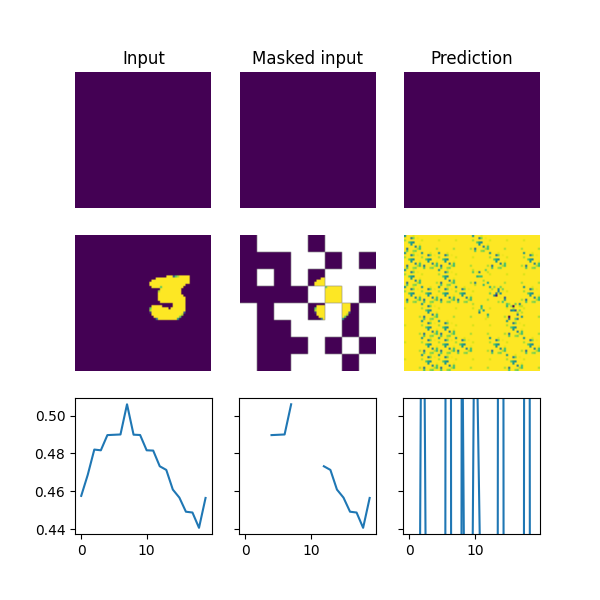

In [10]:
%matplotlib widget

batch = next(iter(dataloader_test))
with torch.no_grad():
    _, pred, mask = mmmae(batch, mask_ratio=mask_ratio)
    
    moving_mask = mask[:, :moving_mnist_embedder.n_patches]
    masked_patches = torch.where(
        torch.unsqueeze(moving_mask, -1) == 0, moving_mnist_embedder.tokenify(batch[0]), np.nan
        )
    masked_moving = moving_mnist_embedder.untokenify(masked_patches)
    pred_moving = moving_mnist_embedder.untokenify(pred[0])

    frame_mask = mask[:, moving_mnist_embedder.n_patches:-mnist_height_embedder.n_patches]
    masked_patches = torch.where(
        torch.unsqueeze(frame_mask, -1) == 0, static_mnist_embedder.tokenify(batch[1]), np.nan
        )
    masked_static = static_mnist_embedder.untokenify(masked_patches)
    pred_static = static_mnist_embedder.untokenify(pred[1])

    height_mask = mask[:, -mnist_height_embedder.n_patches:]
    masked_patches = torch.where(
        torch.unsqueeze(height_mask, -1) == 0, mnist_height_embedder.tokenify(batch[2]), np.nan
        )
    masked_height = mnist_height_embedder.untokenify(masked_patches)
    pred_height = mnist_height_embedder.untokenify(pred[2])

fig, axs = plt.subplots(3, 3, figsize=[6, 6])
axs[0, 0].set_title("Input")
axs[0, 1].set_title("Masked input")
axs[0, 2].set_title("Prediction")
plt_imgs = [ax.imshow(np.zeros([64, 64]), vmin=0, vmax=1) for ax in axs[0]]
for ax_row in axs[:2]:
    for ax in ax_row:
        ax.set_axis_off()

axs[1, 0].imshow(batch[1][0, 0], vmin=0, vmax=1)
axs[1, 1].imshow(masked_static[0, 0], vmin=0, vmax=1)
axs[1, 2].imshow(pred_static[0, 0], vmin=0, vmax=1)
axs[2, 0].plot(range(batch[2].shape[-1]), batch[2][0].flatten())
axs[2, 1].plot(range(batch[2].shape[-1]), masked_height[0].flatten())
axs[2, 1].set_xlim(axs[2, 0].get_xlim())
axs[2, 1].set_ylim(axs[2, 0].get_ylim())
axs[2, 1].set_yticklabels([])
axs[2, 2].plot(range(batch[2].shape[-1]), pred_height[0].flatten())
axs[2, 2].set_xlim(axs[2, 0].get_xlim())
axs[2, 2].set_ylim(axs[2, 0].get_ylim())
axs[2, 2].set_yticklabels([])

def animate(frame):
    plt_imgs[0].set_array(batch[0][0, 0, frame])
    plt_imgs[1].set_array(masked_moving[0, 0, frame])
    plt_imgs[2].set_array(pred_moving[0, 0, frame])
    return plt_imgs

animation = FuncAnimation(fig, animate, frames=20)